# Praxisteil II: Bayessche Hierarchische Modelle

__Bayesian Workflow__

1. Exploration der Daten
2. Bauen des Modells
3. Prior Predictive Check
4. Modell Fitting
5. Convergence Check
6. Posterior Predictive Check
7. Parameter Inferenz

8. Modellvergleich (LM vs. BHM)

9. Modell verbessern

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import pymc3 as pm
import arviz as az
import numpy as np

import math
import warnings
warnings.filterwarnings('ignore')

kwargs_sampler = {'chains': 4,'cores': 4}#, 'return_inferencedata': True}

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [17]:
# Plotting
def plot_by_group(y,x,num_groups,group_idx,trace=None,fit=False):
    
    # Get number of rows and columns to plot
    if num_groups<=3:
        num_cols = num_groups
    else:
        num_cols = 3
    num_rows = math.ceil(num_groups/3)

    # Set up plot
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(20,10), sharex=True, sharey=True)
    ax = np.ravel(ax)

    # Plot each group
    x_range = np.linspace(x.min(), x.max(), 10)
    j = 0
    k = len(group_idx[group_idx==j])
    for i in range(num_groups):
        ax[i].scatter(x[j:k], y[j:k])
        ax[i].set_title(f"Group {i+1}", fontsize=15)
        
        if trace is not None:
            alpha_m = trace['beta_0'][:,i].mean()
            beta_m = trace['beta_1'][:, i].mean()
            
            ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
                       label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
        if fit:
            coef = np.polyfit(x[j:k], y[j:k],1)
            alpha_m = coef[1]
            beta_m = coef[0]
        
            ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
                       label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
            
        
        j += (group_idx==i).sum()
        k += (group_idx==i).sum()

    # Set common x and y axis
    fig.text(0.5, 0.07, 'Price', ha='center', fontsize=20)
    fig.text(0.09, 0.5, 'Sales', va='center', rotation='vertical', fontsize=20)

## Exploration der Daten

In [3]:
# Load data
df = pd.read_csv('../data/dataset_sim.csv')
df.head()

,Sales,Price,Store
0,48.484536,5.749164,0
1,43.640838,4.796067,0
2,48.609230,4.817825,0
3,45.924189,5.680656,0
4,57.832635,3.181501,0


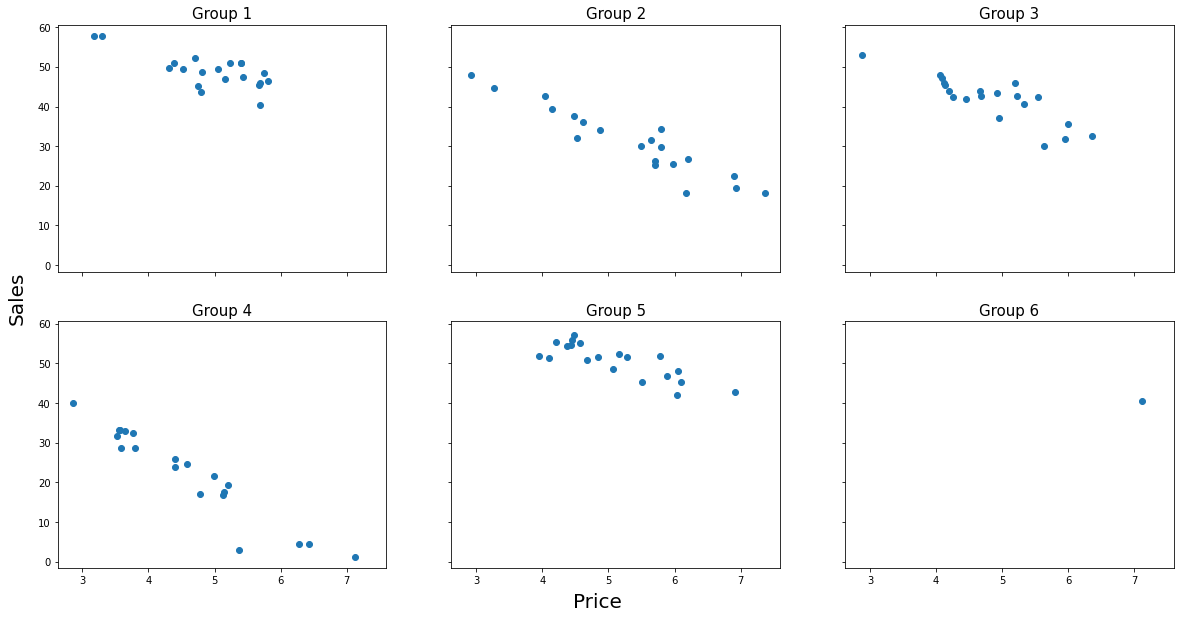

In [18]:
# Plot sales by groups
num_groups = df.Store.nunique()
group_idx = df.Store.to_numpy()

plot_by_group(df['Sales'],df['Price'],num_groups,group_idx)

## Bauen des Modells

### Bayessches Hierarchisches Modell

### Pymc3 Implementierung

In [24]:
# Centering for better convergence
df['Price_centered'] = df['Price'] - df['Price'].mean()

# Group variables
group_idx = df['Store']
num_groups = df['Store'].nunique()

with pm.Model() as hierarchical_linear_model:
    
    # Priors for beta_0 prior (Hyperprior)
    beta_0_mu = pm.Normal('beta_0_mu', mu=0, sd = 100)
    beta_0_sigma = pm.HalfNormal('beta_0_sigma', sd = 100)
    
    # Priors for beta_1 prior (Hyperprior)
    beta_1_mu = pm.Normal('beta_1_mu', mu=0, sd = 100)
    beta_1_sigma = pm.HalfNormal('beta_1_sigma', sd = 100)
    
    # Hyperparameters
    beta_0_scaled = pm.Normal('beta_0_scaled', mu=beta_0_mu, sd=beta_0_sigma, shape=num_groups)
    beta_1 = pm.Normal('beta_1', mu=beta_1_mu, sd=beta_1_sigma, shape=num_groups)
    eps = pm.HalfNormal('eps', 5)
    
    # Calculate mean of normal distribution (conditioning)
    mu = beta_0_scaled[group_idx] + beta_1[group_idx]*df['Price_centered']
    
    # Conditional normal distribution
    sales_pred = pm.Normal('sales_pred',mu=mu,sd=eps,observed=df['Sales'])
    
    beta_0 = pm.Deterministic('beta_0', beta_0_scaled - beta_1 * df['Price'].mean())

## Prior predictive Check

More information about MCMC sampling and convergence checks: 

In [21]:
with hierarchical_linear_model:
    hlm_prior_predictive = pm.sample_prior_predictive()

In [ ]:
# Plot each group 

## Model fitting

In [25]:
with hierarchical_linear_model:
    # Trace
    trace_hierarchical_linear_model = pm.sample(**kwargs_sampler)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta_1, beta_0_scaled, beta_1_sigma, beta_1_mu, beta_0_sigma, beta_0_mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


## Convergence Check

array([[<AxesSubplot:title={'center':'beta_0_mu'}>,
        <AxesSubplot:title={'center':'beta_0_mu'}>],
       [<AxesSubplot:title={'center':'beta_1_mu'}>,
        <AxesSubplot:title={'center':'beta_1_mu'}>],
       [<AxesSubplot:title={'center':'beta_0_scaled\n0'}>,
        <AxesSubplot:title={'center':'beta_0_scaled\n0'}>],
       [<AxesSubplot:title={'center':'beta_0_scaled\n1'}>,
        <AxesSubplot:title={'center':'beta_0_scaled\n1'}>],
       [<AxesSubplot:title={'center':'beta_0_scaled\n2'}>,
        <AxesSubplot:title={'center':'beta_0_scaled\n2'}>],
       [<AxesSubplot:title={'center':'beta_0_scaled\n3'}>,
        <AxesSubplot:title={'center':'beta_0_scaled\n3'}>],
       [<AxesSubplot:title={'center':'beta_0_scaled\n4'}>,
        <AxesSubplot:title={'center':'beta_0_scaled\n4'}>],
       [<AxesSubplot:title={'center':'beta_0_scaled\n5'}>,
        <AxesSubplot:title={'center':'beta_0_scaled\n5'}>],
       [<AxesSubplot:title={'center':'beta_1\n0'}>,
        <AxesSubplot:tit

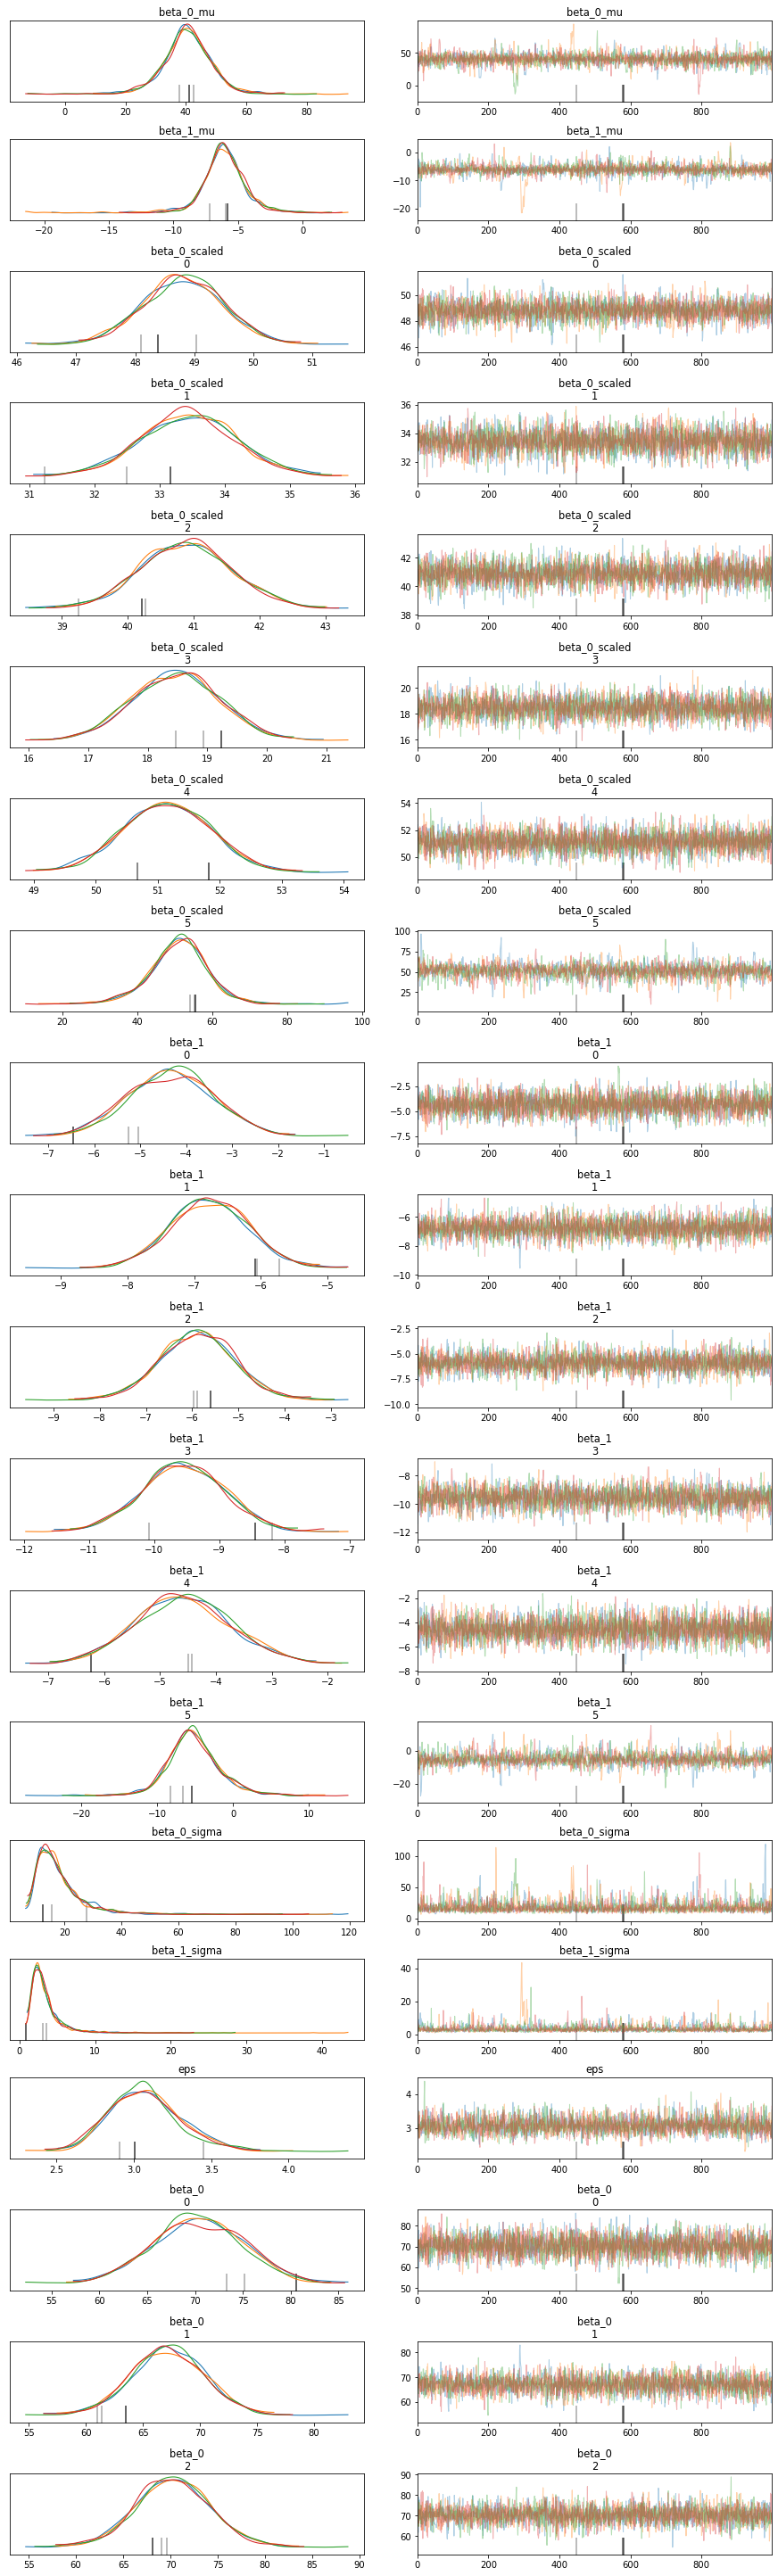

In [27]:
# Analyze the results
az.plot_trace(trace_hierarchical_linear_model)

In [28]:
# Tabular summary
az.summary(trace_hierarchical_linear_model)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta_0_mu,40.424,8.542,24.355,55.750,0.222,0.157,1476.0,1476.0,2095.0,1557.0,1.0
beta_1_mu,-6.087,1.794,-9.289,-2.824,0.059,0.053,928.0,563.0,1553.0,976.0,1.0
beta_0_scaled[0],48.806,0.692,47.451,50.033,0.012,0.008,3583.0,3583.0,3622.0,2627.0,1.0
beta_0_scaled[1],33.447,0.736,32.065,34.872,0.013,0.009,3306.0,3279.0,3299.0,2569.0,1.0
beta_0_scaled[2],40.887,0.690,39.644,42.237,0.012,0.008,3371.0,3371.0,3366.0,2881.0,1.0
beta_0_scaled[3],18.476,0.720,17.180,19.857,0.012,0.009,3499.0,3499.0,3492.0,3020.0,1.0
beta_0_scaled[4],51.140,0.707,49.864,52.516,0.011,0.008,4121.0,4116.0,4118.0,2561.0,1.0
beta_0_scaled[5],51.107,8.182,34.738,65.856,0.197,0.139,1728.0,1728.0,1826.0,1707.0,1.0
beta_1[0],-4.322,0.920,-6.126,-2.707,0.014,0.010,4235.0,4183.0,4265.0,3230.0,1.0
beta_1[1],-6.768,0.586,-7.901,-5.704,0.009,0.007,3910.0,3885.0,3933.0,3107.0,1.0


## Posterior Predictive Check

In [29]:
# Predict observations from the model by posterior predictive sampling
with hierarchical_linear_model:
    ppc_lhm = pm.sample_posterior_predictive(
        trace_hierarchical_linear_model, var_names=['beta_0','beta_1','sales_pred'], random_seed=58
    )

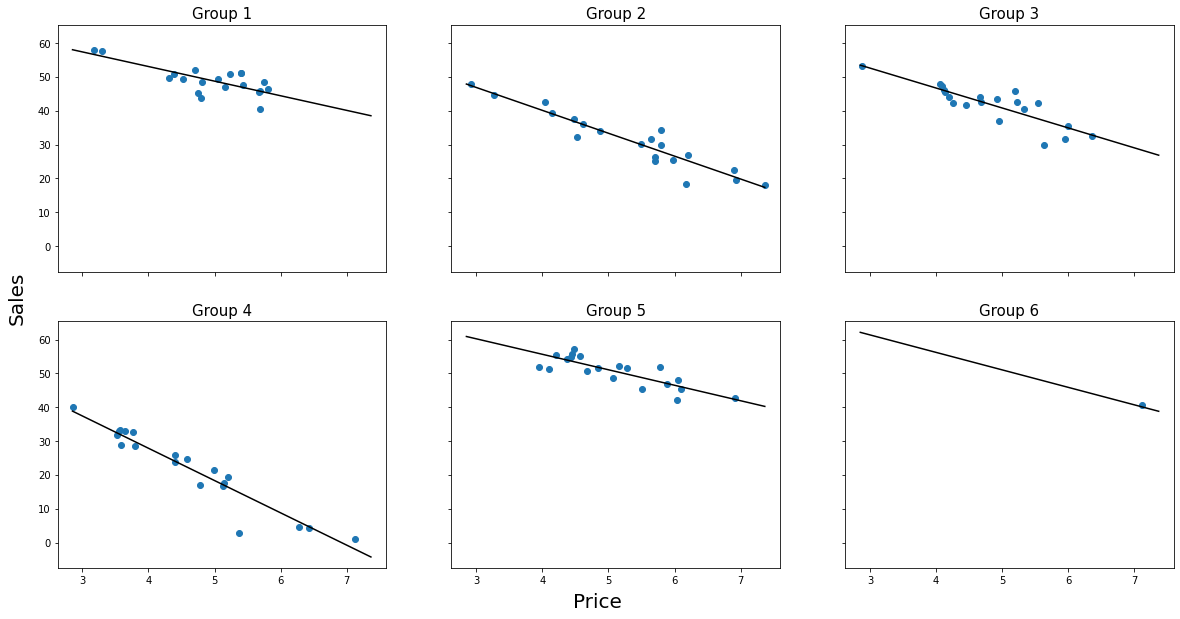

In [30]:
# Plot by group
plot_by_group(df['Sales'],df['Price'],num_groups,group_idx,trace_hierarchical_linear_model)

<AxesSubplot:xlabel='sales_pred'>

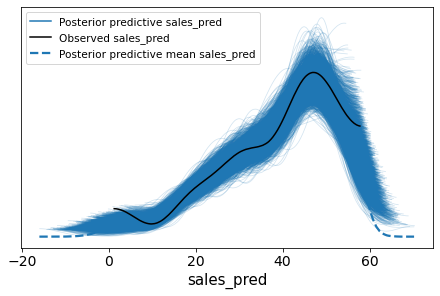

In [31]:
# Alternatively we can use the plot the conditional distribution of y
idata = az.from_pymc3(trace_hierarchical_linear_model, posterior_predictive=ppc_lhm)
az.plot_ppc(idata)

## Parameter inference

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

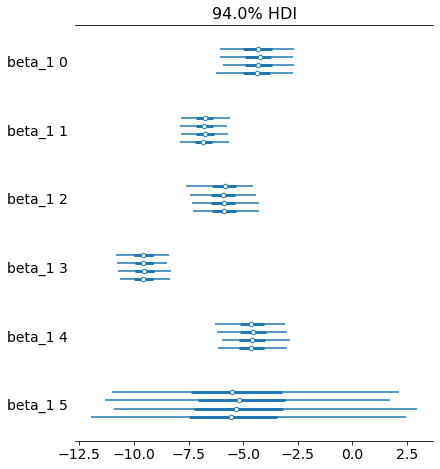

In [32]:
# Analyze the results
#az.plot_trace(trace_hierarchical_linear_model, var_names=['beta_0','beta_1'])
#az.plot_posterior(trace_hierarchical_linear_model) 
az.plot_forest(trace_hierarchical_linear_model, var_names='beta_1')

## Modellvergleich

In [33]:
# Build linear model again
with pm.Model() as linear_model:
    
    # Hyperparameters
    beta_0 = pm.Normal('beta_0', mu=0, sd=100)
    beta_1 = pm.Normal('beta_1', mu=-20, sd=50)
    eps = pm.HalfNormal('eps', 5)
    
    # Calculate mean of normal distribution (conditioning)
    #mu = pm.Deterministic('mu', beta_0 + beta_1*df['Price'])
    mu = beta_0 + beta_1*df['Price']
    
    # Conditional normal distribution
    sales_pred = pm.Normal('sales_pred',mu=mu,sd=eps,observed=df['Sales'])
    
    # Sample
    trace_linear_model = pm.sample(**kwargs_sampler)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta_1, beta_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [34]:
cmp_df = az.compare({'Linear model': trace_linear_model,
                    'Hierarchical linear model': trace_hierarchical_linear_model},ic='waic')
cmp_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Hierarchical linear model,0,-262.095,10.3297,0,1,6.48056,0,True,log
Linear model,1,-397.064,2.88097,134.969,3.05141e-46,10.069,9.71731,False,log


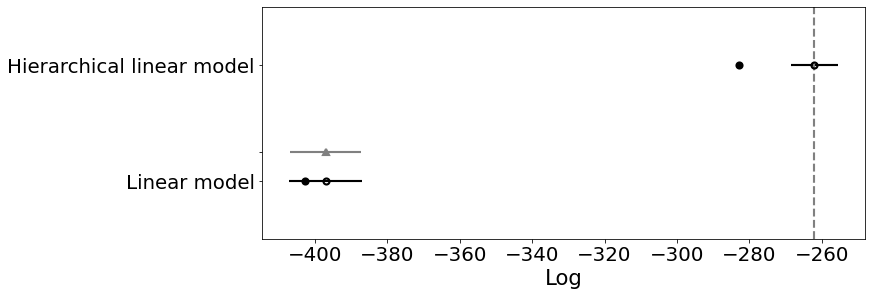

In [35]:
ax = az.plot_compare(cmp_df, figsize=(12, 4))

## Conclusion